# **Final-Project**

In [220]:
#Improt modules
import requests
import re
import json
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from collections import Counter
from matplotlib.ticker import FuncFormatter

In [168]:
#url
base_url = "https://www.imdb.com/list/ls048276758/"
headers = {"User-Agent": "Mozilla/5.0"}

### **1.Data Cleaning and Wrangling**

#### **1.1 Web scraping**

In [170]:
#web scraping top 1000 movies of all the time from IMDB
all_movies = []

# Loop through each page in increments of 250 (assuming IMDb paginates by 250 items per page)
for start in range(1, 1001, 250):
    url = f"{base_url}?start={start}"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        # Use a regular expression to find the JSON-LD script in the HTML
        json_ld_data = re.search(r'<script type="application/ld\+json">(.*?)</script>', response.text, re.DOTALL)
        
        if json_ld_data:
            # Load the JSON data from the matched text
            movies_data = json.loads(json_ld_data.group(1))
            
            # Check if the JSON contains the list of movies
            if "itemListElement" in movies_data:
                movies = movies_data["itemListElement"]
                
                # Extract relevant fields for each movie
                for movie in movies:
                    movie_item = movie['item']
                    
                    # Extract fields with fallbacks for missing values
                    movie_data = {
                        "Title": movie_item.get('name', 'N/A'),
                        "URL": movie_item.get('url', 'N/A'),
                        "Description": movie_item.get('description', 'N/A'),
                        "Rating": movie_item.get('aggregateRating', {}).get('ratingValue', 'N/A'),
                        "BestRating": movie_item.get('aggregateRating', {}).get('bestRating', 'N/A'),
                        "WorstRating": movie_item.get('aggregateRating', {}).get('worstRating', 'N/A'),
                        "RatingCount": movie_item.get('aggregateRating', {}).get('ratingCount', 'N/A'),
                        "Image": movie_item.get('image', 'N/A'),
                        "ContentRating": movie_item.get('contentRating', 'N/A'),
                        "Genre": movie_item.get('genre', 'N/A'),
                        "Duration": movie_item.get('duration', 'N/A')
                    }
                    
                    all_movies.append(movie_data)
        else:
            print("No JSON-LD data found on the page.")
    else:
        print(f"Failed to retrieve page starting at {start}. Status code: {response.status_code}")

# Save all extracted movie data to a JSON file
with open("movies_data.json", "w") as json_file:
    json.dump(all_movies, json_file, indent=4)

print(f"Data for {len(all_movies)} movies successfully saved to 'movies_data.json'")


Data for 1000 movies successfully saved to 'movies_data.json'


In [ ]:
# save data in to CSV
with open('movies_data.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = 'movies_data.csv'
df.to_csv(csv_file_path, index=False, encoding='utf-8')
#print(f"Data successfully saved to '{csv_file_path}'")



#### **1.2Merging Scraped Data and Data from Kaggle**

In [174]:
#merging the scraped data and data from kaggle 
movies_1million = pd.read_csv('TMDB_all_movies.csv')  
movies_1000 = pd.read_csv('movies_data.csv')

# Convert all column names to lowercase
movies_1million1.columns = movies_1million1.columns.str.lower()
movies_1000.columns = movies_1000.columns.str.lower()

# Ensure the 'title' column exists in both DataFrames
if 'title' in movies_1000.columns and 'title' in movies_1million1.columns:
    # Merge data: Use movies_1000 as the main dataset, merge on 'title' using a left join
    merged_data = pd.merge(
        movies_1000,
        movies_1million1,
        on='title',
        how='left',
        suffixes=('_1000', '_1million')  # Add suffixes to differentiate columns
    )

    # Optional: Drop duplicate columns if necessary
    merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

    # Print the number of rows and unique titles after merging
    print(f"Number of rows after merging: {merged_data.shape[0]}")
    print(f"Number of unique titles after merging: {merged_data['title'].nunique()}")
else:
    print("The 'title' column is missing in one of the DataFrames.")

# Display the resulting merged DataFrame
merged_data.head()


Number of rows after merging: 1000
Number of unique titles after merging: 250


,title,url,description,rating,bestrating,worstrating,ratingcount,image,contentrating,genre,...,spoken_languages,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,poster_path
0,The Godfather,https://www.imdb.com/title/tt0068646/,The aging patriarch of an organized crime dyna...,9.2,10,1,2073753,https://m.media-amazon.com/images/M/MV5BYTJkNG...,R,"Crime, Drama",...,"English, Italiano, Latin","Robert Duvall, Frank Sivero, Sterling Hayden, ...",Francis Ford Coppola,Gordon Willis,"Mario Puzo, Francis Ford Coppola","Albert S. Ruddy, Robert Evans, Francis Ford Co...",Nino Rota,9.2,2073116.0,/3bhkrj58Vtu7enYsRolD1fZdja1.jpg
1,Tôkyô monogatari,https://www.imdb.com/title/tt0046438/,An old couple visit their children and grandch...,8.1,10,1,71263,https://m.media-amazon.com/images/M/MV5BODdkNz...,Not Rated,Drama,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shichinin no samurai,https://www.imdb.com/title/tt0047478/,Farmers from a village exploited by bandits hi...,8.6,10,1,376521,https://m.media-amazon.com/images/M/MV5BZjliMW...,Not Rated,Drama,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The Godfather Part II,https://www.imdb.com/title/tt0071562/,The early life and career of Vito Corleone in ...,9.0,10,1,1399802,https://m.media-amazon.com/images/M/MV5BNzc1OW...,R,"Crime, Drama",...,"English, Italiano, Latin, Español","John Megna, Kathleen Beller, Joseph Della Sort...",Francis Ford Coppola,Gordon Willis,"Mario Puzo, Francis Ford Coppola",Francis Ford Coppola,Nino Rota,9.0,1399410.0,/hek3koDUyRQk7FIhPXsa6mT2Zc3.jpg
4,Casablanca,https://www.imdb.com/title/tt0034583/,A cynical expatriate American cafe owner strug...,8.5,10,1,620281,https://m.media-amazon.com/images/M/MV5BNWEzN2...,PG,"Drama, Romance, War",...,"Deutsch, Français, Italiano, English","Jacques Vanaire, Alberto Morin, Trude Berliner...",Michael Curtiz,Arthur Edeson,"Howard Koch, Joan Alison, Julius J. Epstein, P...","Jack L. Warner, Hal B. Wallis",Max Steiner,8.5,620127.0,/5K7cOHoay2mZusSLezBOY0Qxh8a.jpg


#### **1.3 Data Cleaning**

##### **1.31 droping unncessary columns**

In [191]:
#droping unncessary columns
columns_to_keep = [
    'title', 'url', 'description', 'rating',
    'ratingcount', 'image', 'contentrating', 'genre', 'duration', 
    'vote_average', 'release_date', 
    'imdb_votes', 'original_language', 
    'popularity', 'genres', 'cast', 'director', 'writers', 
    'production_companies', 'production_countries', 'budget','revenue'
    
]
df_merged_filtered = merged_data[columns_to_keep]
#print(df_merged_filtered)

##### **1.32 Drop duplicates**

In [ ]:
#drop duplicated rows based on movies title
df_merged =  df_merged_filtered.drop_duplicates(subset=['title'])
df_merged.reset_index(drop=True, inplace=True)


##### **1.33 convert duration in time format**

In [184]:
# Rename the column if necessary
if 'duration' not in df_merged.columns:
    if 'actual_duration_column' in df_merged.columns:  # Check if the source column exists
        df_merged.rename(columns={'actual_duration_column': 'duration'}, inplace=True)
    else:
        raise KeyError("The 'duration' column or 'actual_duration_column' is missing from the DataFrame.")

# Function to parse and convert the duration
def convert_duration_to_time(duration):
    # Handle non-string or missing values
    if not isinstance(duration, str) or pd.isna(duration):
        return None  # Return None for invalid or missing durations
    
    # Remove "PT", split by "H" and "M"
    duration = duration.replace("PT", "")
    hours = 0
    minutes = 0
    if "H" in duration:
        hours, duration = duration.split("H")
        hours = int(hours)
    if "M" in duration:
        minutes = int(duration.replace("M", ""))
    # Return the compact time format with seconds as "00"
    return f"{hours}:{minutes:02d}:00"

# Apply the conversion with .loc to avoid the warning
df_merged.loc[:, 'duration_time'] = df_merged['duration'].apply(convert_duration_to_time)

#print(df_merged.head())


In [189]:


# # Calculate the number of null values in each column
# null_counts = df_merged.isnull().sum()

# # Filter columns with null values
# columns_with_nulls = null_counts[null_counts > 0]

# # Display columns with null values and their counts
# print("Columns with null values and their counts:")
# print(columns_with_nulls)


##### **1.34 Drop null values**

In [ ]:
df_merged_cleaned = df_merged.dropna()
df_merged_cleaned.reset_index(drop=True, inplace=True)

# Display the shape of the new DataFrame
# print(f"Original DataFrame shape: {df_merged.shape}")
# print(f"DataFrame shape after dropping null values: {df_merged_cleaned.shape}")

In [194]:
# drop duration
columns_to_drop = ['duration']
existing_columns_to_drop = [col for col in columns_to_drop if col in df_merged_cleaned.columns]

if existing_columns_to_drop:
    # Drop the existing columns
    df_merged_cleaned = df_merged_cleaned.drop(columns=existing_columns_to_drop)
    print(f"Dropped columns: {existing_columns_to_drop}")
else:
    print(f"No columns to drop from the specified list: {columns_to_drop}")

# Reset the index to start from 0
df_merged_cleaned = df_merged_cleaned.reset_index(drop=True)






No columns to drop from the specified list: ['duration']


## **2. Storing Data in to Database**

##### **2.1  Creating Tables in Data base**

In [195]:


# Connect to the database
conn = pymysql.connect(
    host='mysql.clarksonmsda.org',
    port=3306,
    user='ia626',
    passwd='ia626clarkson',
    db='ia626',
    autocommit=True
)
cur = conn.cursor()


In [ ]:

# SQL commands to create tables
create_movies_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movies (
    movie_id INT AUTO_INCREMENT PRIMARY KEY,
    title VARCHAR(255) NOT NULL,
    url TEXT,
    description TEXT,
    rating FLOAT,
    ratingcount INT,
    image TEXT,
    contentrating VARCHAR(50),
    vote_average FLOAT,
    release_date DATE,
    original_language VARCHAR(50),
    popularity FLOAT,
    budget BIGINT,
    revenue BIGINT,
    duration_time VARCHAR(50)
);
"""

create_genres_table = """
CREATE TABLE IF NOT EXISTS berhemd_Genres (
    genre_id INT AUTO_INCREMENT PRIMARY KEY,
    genre_name VARCHAR(100) UNIQUE NOT NULL
);
"""

create_movie_genre_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movie_Genre (
    mapping_id INT AUTO_INCREMENT PRIMARY KEY,
    movie_id INT,
    genre_id INT,
    FOREIGN KEY (movie_id) REFERENCES berhemd_Movies(movie_id) ON DELETE CASCADE,
    FOREIGN KEY (genre_id) REFERENCES  berhemd_Genres(genre_id) ON DELETE CASCADE
);
"""

create_cast_table = """
CREATE TABLE IF NOT EXISTS berhemd_Cast (
    cast_id INT AUTO_INCREMENT PRIMARY KEY,
    cast_name VARCHAR(255) UNIQUE NOT NULL
);
"""

create_movie_cast_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movie_Cast (
    mapping_id INT AUTO_INCREMENT PRIMARY KEY,
    movie_id INT,
    cast_id INT,
    FOREIGN KEY (movie_id) REFERENCES berhemd_Movies(movie_id) ON DELETE CASCADE,
    FOREIGN KEY (cast_id) REFERENCES berhemd_Cast(cast_id) ON DELETE CASCADE
);
"""

create_directors_table = """
CREATE TABLE IF NOT EXISTS berhemd_Directors (
    director_id INT AUTO_INCREMENT PRIMARY KEY,
    director_name VARCHAR(255) UNIQUE NOT NULL
);
"""

create_movie_director_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movie_Director (
    mapping_id INT AUTO_INCREMENT PRIMARY KEY,
    movie_id INT,
    director_id INT,
    FOREIGN KEY (movie_id) REFERENCES berhemd_Movies(movie_id) ON DELETE CASCADE,
    FOREIGN KEY (director_id) REFERENCES berhemd_Directors(director_id) ON DELETE CASCADE
);
"""

create_writers_table = """
CREATE TABLE IF NOT EXISTS berhemd_Writers (
    writer_id INT AUTO_INCREMENT PRIMARY KEY,
    writer_name VARCHAR(255) UNIQUE NOT NULL
);
"""

create_movie_writer_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movie_Writer (
    mapping_id INT AUTO_INCREMENT PRIMARY KEY,
    movie_id INT,
    writer_id INT,
    FOREIGN KEY (movie_id) REFERENCES berhemd_Movies(movie_id) ON DELETE CASCADE,
    FOREIGN KEY (writer_id) REFERENCES berhemd_Writers(writer_id) ON DELETE CASCADE
);
"""

create_movie_production_table = """
CREATE TABLE IF NOT EXISTS berhemd_Movie_Production (
    production_id INT AUTO_INCREMENT PRIMARY KEY,
    movie_id INT,
    production_company VARCHAR(255),
    production_country VARCHAR(100),
    FOREIGN KEY (movie_id) REFERENCES berhemd_Movies(movie_id) ON DELETE CASCADE
);
"""

# Execute the SQL commands
table_commands = [
    create_movies_table,
    create_genres_table,
    create_movie_genre_table,
    create_cast_table,
    create_movie_cast_table,
    create_directors_table,
    create_movie_director_table,
    create_writers_table,
    create_movie_writer_table,
    create_movie_production_table
]

for command in table_commands:
    try:
        cur.execute(command)
        print(f"Table created successfully:\n{command.split('(')[0].strip()}")
    except Exception as e:
        print(f"Error creating table: {e}")

# Close the connection
cur.close()
conn.close()


##### **2.2 Inserted Cleaned data in to Data base**

In [ ]:

conn = pymysql.connect(
    host='mysql.clarksonmsda.org',
    port=3306,
    user='ia626',
    passwd='ia626clarkson',
    db='ia626',
    autocommit=True
)
cur = conn.cursor()

# Insert data into the Movies table
def insert_movies(dataframe):
    movies_query = """
    INSERT INTO berhemd_Movies (title, url, description, rating, ratingcount, image, contentrating, 
                        vote_average, release_date, original_language, popularity, 
                        budget, revenue, duration_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """
    for _, row in dataframe.iterrows():
        cur.execute(movies_query, (
            row['title'], row['url'], row['description'], row['rating'], row['ratingcount'],
            row['image'], row['contentrating'], row['vote_average'], row['release_date'],
            row['original_language'], row['popularity'], row['budget'], row['revenue'], 
            row['duration_time']
        ))

# Insert data into the Genres table and create mappings
def insert_genres(dataframe):
    genres_query = "INSERT IGNORE INTO berhemd_Genres (genre_name) VALUES (%s)"
    movie_genre_query = "INSERT INTO berhemd_Movie_Genre (movie_id, genre_id) VALUES (%s, %s)"
    
    for _, row in dataframe.iterrows():
        if row['genres']:
            genres = row['genres'].split(', ')  # Assuming genres are comma-separated
            for genre in genres:
                # Insert genre into Genres table
                cur.execute(genres_query, (genre,))
                # Get genre_id
                cur.execute("SELECT genre_id FROM berhemd_Genres WHERE genre_name = %s", (genre,))
                genre_id = cur.fetchone()[0]
                # Map genre to movie
                cur.execute("SELECT movie_id FROM berhemd_Movies WHERE title = %s", (row['title'],))
                movie_id = cur.fetchone()[0]
                cur.execute(movie_genre_query, (movie_id, genre_id))

# Insert data into the Cast table and create mappings
def insert_cast(dataframe):
    cast_query = "INSERT IGNORE INTO berhemd_Cast (cast_name) VALUES (%s)"
    movie_cast_query = "INSERT INTO berhemd_Movie_Cast (movie_id, cast_id) VALUES (%s, %s)"
    
    for _, row in dataframe.iterrows():
        if row['cast']:
            cast_members = row['cast'].split(', ')  # Assuming cast members are comma-separated
            for cast_member in cast_members:
                # Insert cast member into Cast table
                cur.execute(cast_query, (cast_member,))
                # Get cast_id
                cur.execute("SELECT cast_id FROM berhemd_Cast WHERE cast_name = %s", (cast_member,))
                cast_id = cur.fetchone()[0]
                # Map cast member to movie
                cur.execute("SELECT movie_id FROM berhemd_Movies WHERE title = %s", (row['title'],))
                movie_id = cur.fetchone()[0]
                cur.execute(movie_cast_query, (movie_id, cast_id))

# Insert data into the Directors table and create mappings
def insert_directors(dataframe):
    directors_query = "INSERT IGNORE INTO berhemd_Directors (director_name) VALUES (%s)"
    movie_director_query = "INSERT INTO berhemd_Movie_Director (movie_id, director_id) VALUES (%s, %s)"
    
    for _, row in dataframe.iterrows():
        if row['director']:
            directors = row['director'].split(', ')  # Assuming directors are comma-separated
            for director in directors:
                # Insert director into Directors table
                cur.execute(directors_query, (director,))
                # Get director_id
                cur.execute("SELECT director_id FROM berhemd_Directors WHERE director_name = %s", (director,))
                director_id = cur.fetchone()[0]
                # Map director to movie
                cur.execute("SELECT movie_id FROM berhemd_Movies WHERE title = %s", (row['title'],))
                movie_id = cur.fetchone()[0]
                cur.execute(movie_director_query, (movie_id, director_id))

# Insert data into the Writers table and create mappings
def insert_writers(dataframe):
    writers_query = "INSERT IGNORE INTO berhemd_Writers (writer_name) VALUES (%s)"
    movie_writer_query = "INSERT INTO berhemd_Movie_Writer (movie_id, writer_id) VALUES (%s, %s)"
    
    for _, row in dataframe.iterrows():
        if row['writers']:
            writers = row['writers'].split(', ')  # Assuming writers are comma-separated
            for writer in writers:
                # Insert writer into Writers table
                cur.execute(writers_query, (writer,))
                # Get writer_id
                cur.execute("SELECT writer_id FROM berhemd_Writers WHERE writer_name = %s", (writer,))
                writer_id = cur.fetchone()[0]
                # Map writer to movie
                cur.execute("SELECT movie_id FROM berhemd_Movies WHERE title = %s", (row['title'],))
                movie_id = cur.fetchone()[0]
                cur.execute(movie_writer_query, (movie_id, writer_id))

# Insert data into the Movie_Production table
def insert_production(dataframe):
    production_query = """
    INSERT INTO berhemd_Movie_Production (movie_id, production_company, production_country) 
    VALUES (%s, %s, %s)
    """
    for _, row in dataframe.iterrows():
        if row['production_companies'] or row['production_countries']:
            production_companies = row['production_companies'].split(', ')
            production_countries = row['production_countries'].split(', ')
            for company, country in zip(production_companies, production_countries):
                cur.execute("SELECT movie_id FROM berhemd_Movies WHERE title = %s", (row['title'],))
                movie_id = cur.fetchone()[0]
                cur.execute(production_query, (movie_id, company, country))

# Populate all tables
try:
    insert_movies(df_merged_cleaned)
    insert_genres(df_merged_cleaned)
    insert_cast(df_merged_cleaned)
    insert_directors(df_merged_cleaned)
    insert_writers(df_merged_cleaned)
    insert_production(df_merged_cleaned)
    print("Data populated successfully.")
except Exception as e:
    print(f"Error populating data: {e}")
finally:
    cur.close()
    conn.close()


Data populated successfully.


## **3 Explaratory Data Analysis**

##### **distribution of movie ratings**

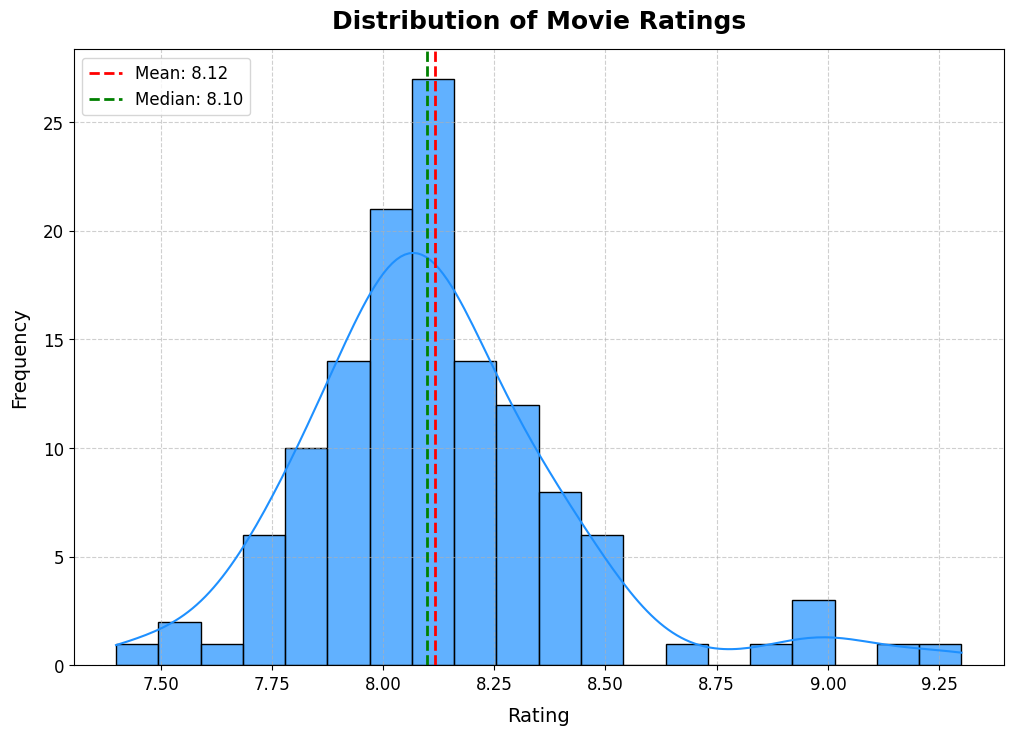

In [ ]:
# Plot the distribution of movie ratings
plt.figure(figsize=(12, 8))  
sns.histplot(
    df_merged_cleaned['rating'], 
    bins=20, 
    kde=True, 
    color='dodgerblue', 
    edgecolor='black', 
    alpha=0.7
)

# Enhance plot aesthetics
plt.title('Distribution of Movie Ratings', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Rating', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add mean and median lines
mean_rating = df_merged_cleaned['rating'].mean()
median_rating = df_merged_cleaned['rating'].median()

plt.axvline(mean_rating, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rating:.2f}')
plt.axvline(median_rating, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rating:.2f}')

plt.legend(fontsize=12, loc='upper left')
plt.show()


##### **Top 10 Most Popular Genres**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/3571975895.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


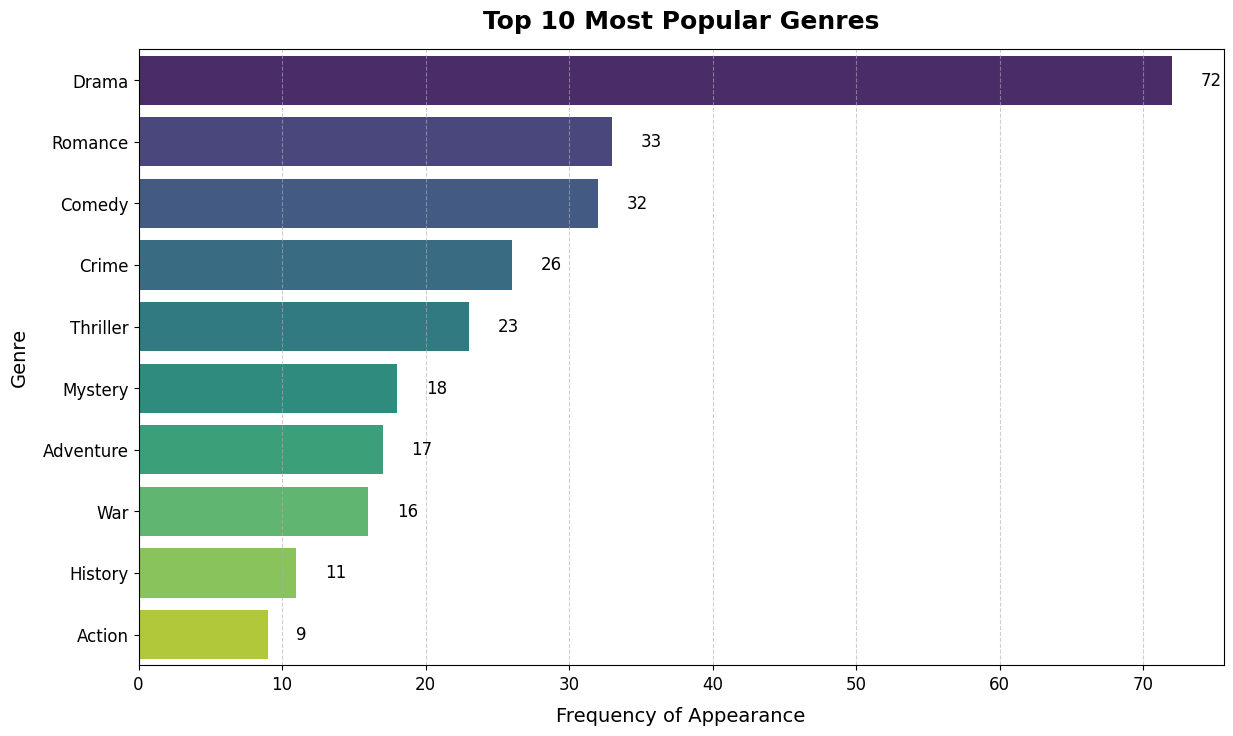

In [219]:
genre_counts = Counter(
    [genre for genres in df_merged_cleaned['genres'].dropna() for genre in genres.split(', ')]
)
top_genres = dict(genre_counts.most_common(10))
genre_df = pd.DataFrame(list(top_genres.items()), columns=['Genre', 'Frequency']).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=genre_df, 
    x='Frequency', 
    y='Genre', 
    palette='viridis', 
    orient='h'  # Horizontal bars for better readability
)

# Enhance plot aesthetics
plt.title('Top 10 Most Popular Genres', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Frequency of Appearance', fontsize=14, labelpad=10)
plt.ylabel('Genre', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) 

# Annotate bar values with exact counts
for index, value in enumerate(genre_df['Frequency']):
    plt.text(value + 2, index, f"{value:,}", va='center', fontsize=12, color='black')

plt.show()


##### **Average Revenue by Budget Range**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/3107704020.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


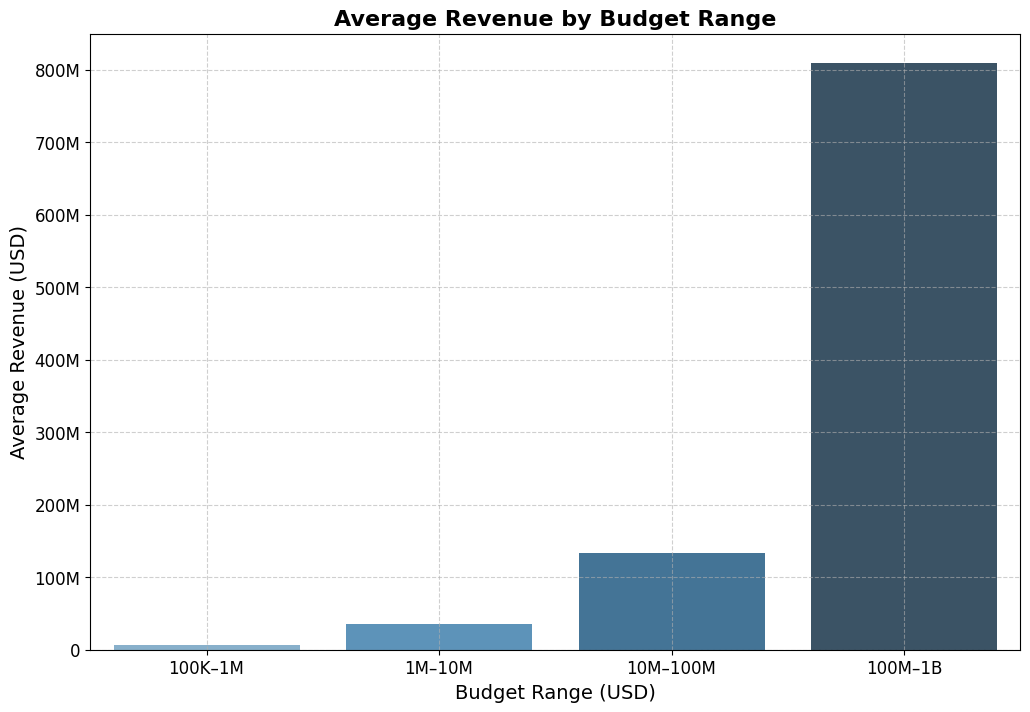

In [ ]:

def format_millions(value, tick_number):
    if value >= 1e9:
        return f'{int(value / 1e9)}B'  # Format as billions without decimals
    elif value >= 1e6:
        return f'{int(value / 1e6)}M'  # Format as millions without decimals
    else:
        return f'{int(value)}'        


df_merged_cleaned['budget_bins'] = pd.cut(
    df_merged_cleaned['budget'], 
    bins=[100000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000], 
    labels=['100K–1M', '1M–10M', '10M–100M', '100M–1B'], 
    include_lowest=True
)

# Aggregate average revenue per budget bin (explicitly pass observed=False)
budget_vs_revenue = df_merged_cleaned.groupby(
    'budget_bins', observed=False
)['revenue'].mean().reset_index()

# Create a bar plot for visualizing average revenue by budget range
plt.figure(figsize=(12, 8))
sns.barplot(
    data=budget_vs_revenue, 
    x='budget_bins', 
    y='revenue', 
    palette='Blues_d'
)

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_millions))


plt.title('Average Revenue by Budget Range', fontsize=16, fontweight='bold')
plt.xlabel('Budget Range (USD)', fontsize=14)
plt.ylabel('Average Revenue (USD)', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()


##### **Top 10 Directors by Average Movie Rating**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/4222424272.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


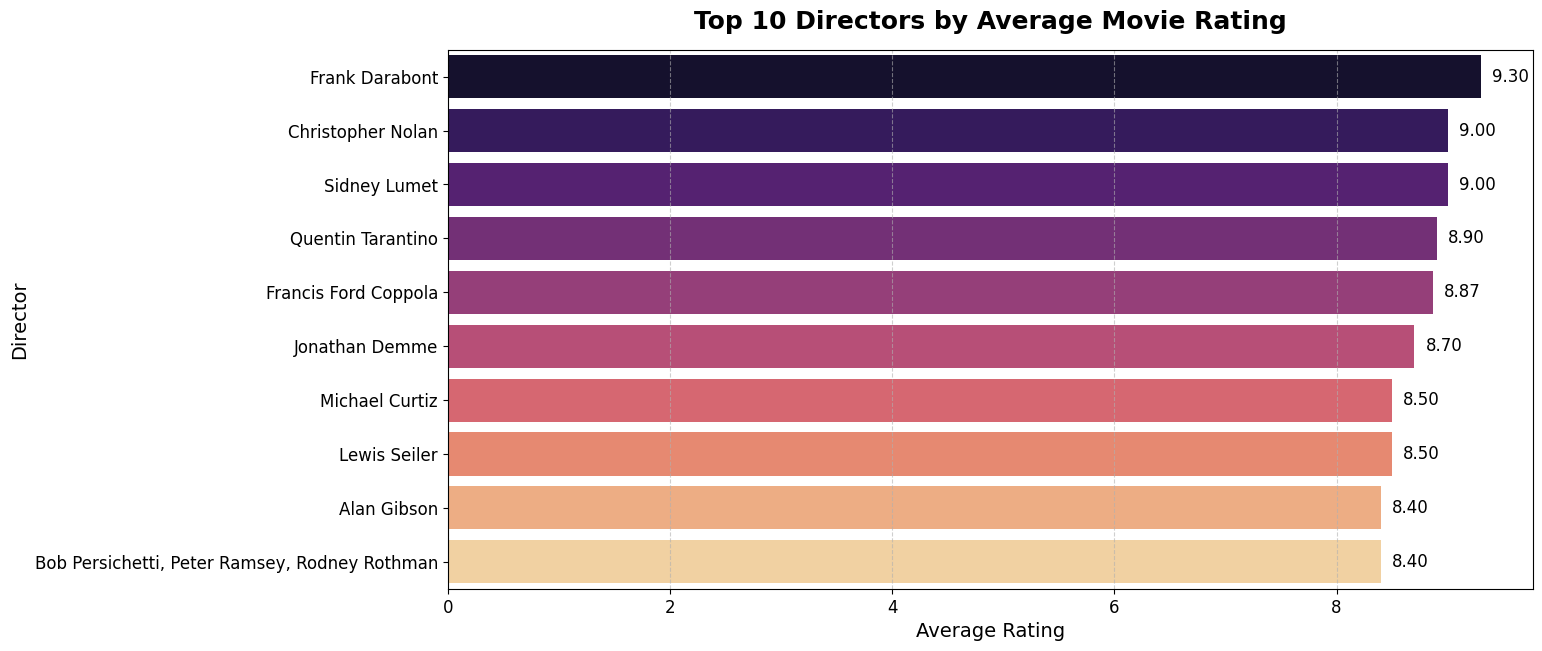

In [222]:

top_directors = (
    df_merged_cleaned.explode('director') 
    .groupby('director')['rating']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(14, 7))
sns.barplot(
    x=top_directors.values, 
    y=top_directors.index, 
    palette='magma', 
    orient='h'  # Horizontal orientation for readability
)

# Add ratings to the end of each bar
for index, value in enumerate(top_directors.values):
    plt.text(value + 0.1, index, f"{value:.2f}", va='center', fontsize=12)

plt.title('Top 10 Directors by Average Movie Rating', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Director', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6, axis='x')  

plt.show()


##### **Evolution of Movie Production Over the Years**

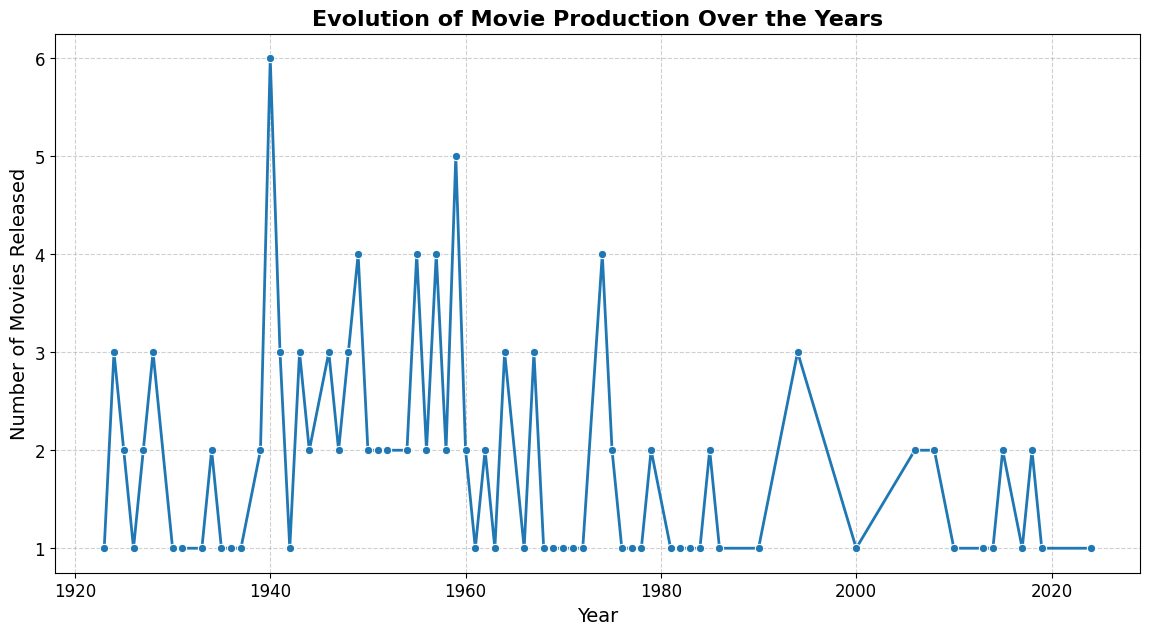

In [223]:

df_merged_cleaned['release_year'] = pd.to_datetime(df_merged_cleaned['release_date']).dt.year

movies_per_year = df_merged_cleaned['release_year'].value_counts().sort_index()

plt.figure(figsize=(14, 7))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker='o', linestyle='-', linewidth=2)

plt.title('Evolution of Movie Production Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies Released', fontsize=14)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


##### **Top 10 Actors with Most Movie Appearances**

/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/2974096759.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


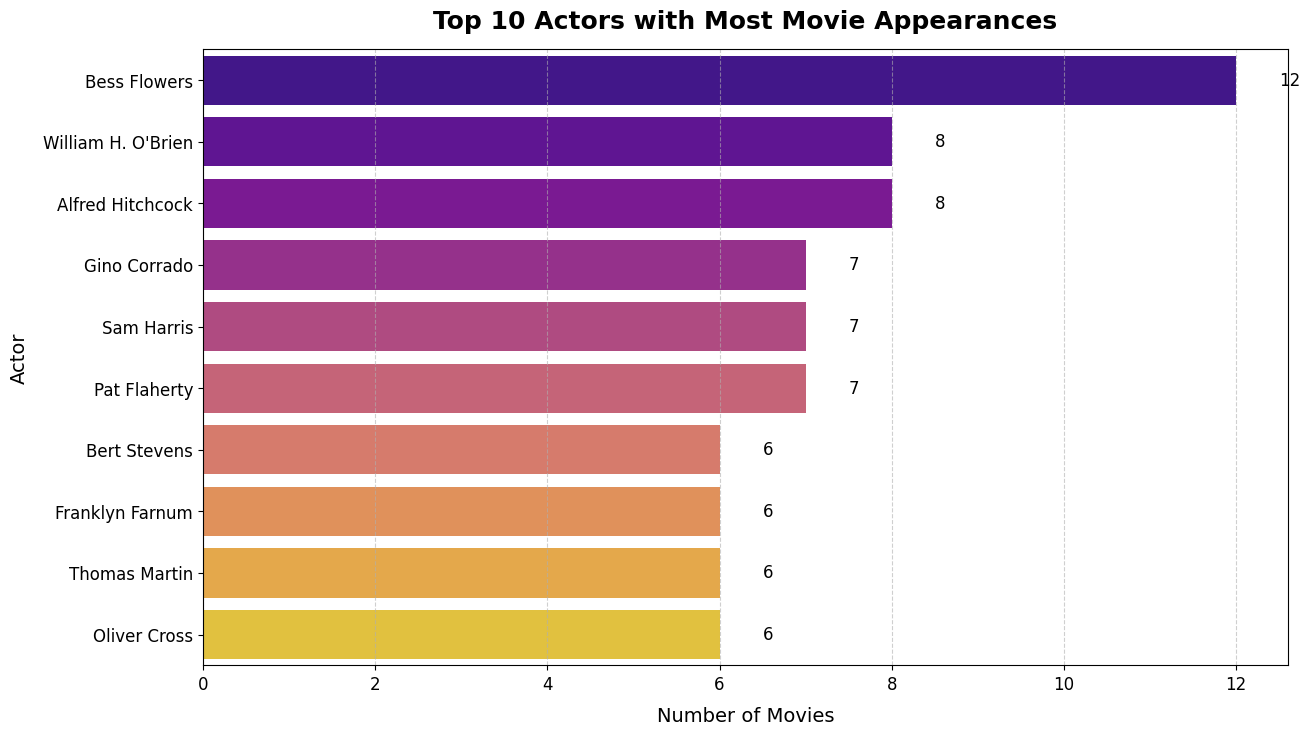

In [ ]:
actor_counts = Counter(
    [actor for cast in df_merged_cleaned['cast'].dropna() for actor in cast.split(', ')]
)
top_actors = dict(actor_counts.most_common(10))

actor_df = pd.DataFrame(list(top_actors.items()), columns=['Actor', 'Number of Movies']).sort_values(by='Number of Movies', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=actor_df, 
    x='Number of Movies', 
    y='Actor', 
    palette='plasma', 
    orient='h'  # Horizontal bars for better readability
)

# Enhance plot aesthetics
plt.title('Top 10 Actors with Most Movie Appearances', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Number of Movies', fontsize=14, labelpad=10)
plt.ylabel('Actor', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6) 
# Annotate bar values with exact counts
for index, value in enumerate(actor_df['Number of Movies']):
    plt.text(value + 0.5, index, f"{value:,}", va='center', fontsize=12, color='black')

plt.show()


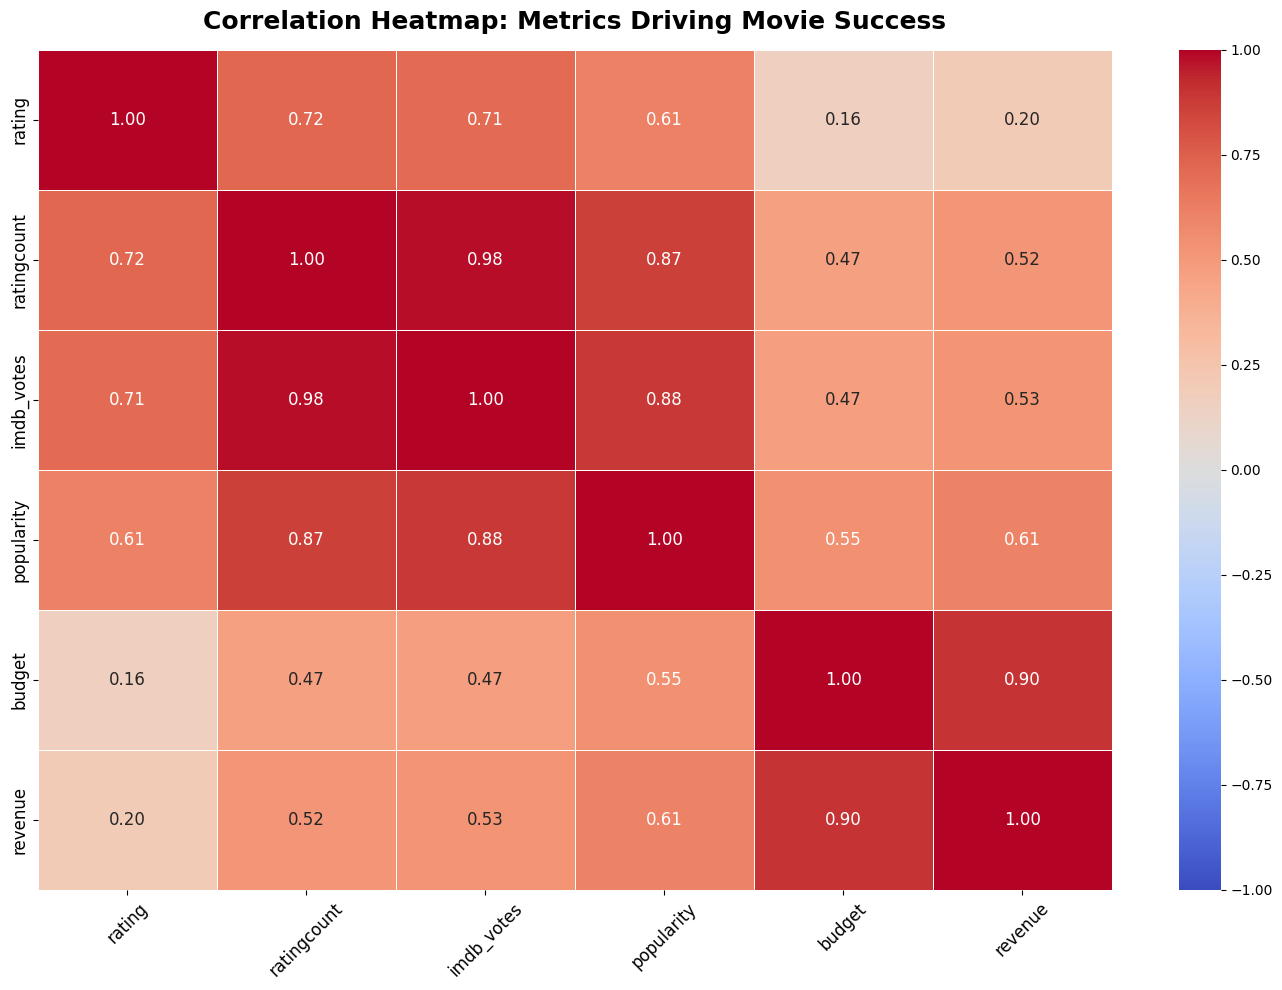

In [241]:


# Convert 'duration_time' to total minutes
df_merged_cleaned['duration_time'] = pd.to_timedelta(df_merged_cleaned['duration_time']).dt.total_seconds() / 60

# Select relevant numeric columns for correlation analysis
selected_columns = ['rating', 'ratingcount', 'imdb_votes', 'popularity', 'budget', 'revenue']
numeric_columns = df_merged_cleaned[selected_columns]

# Ensure all columns are numeric and drop rows with missing values
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce').dropna()

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))  # Larger figure for clarity
sns.heatmap(
    correlation_matrix, 
    annot=True,  # Show correlation values
    fmt=".2f",   # Format values to two decimal places
    cmap='coolwarm',  # Diverging colormap for better visualization
    vmin=-1, vmax=1,  # Correlation range from -1 to 1
    linewidths=0.5,  # Add gridlines between cells
    annot_kws={"size": 12}  # Increase annotation font size
)

# Add title and labels
plt.title('Correlation Heatmap: Metrics Driving Movie Success', fontsize=18, fontweight='bold', pad=15)
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for readability
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout for better fit
plt.show()


/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/3995647607.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/7k/v_jnhg6d6tbfgjf3wx5_8lfr0000gn/T/ipykernel_21248/3995647607.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


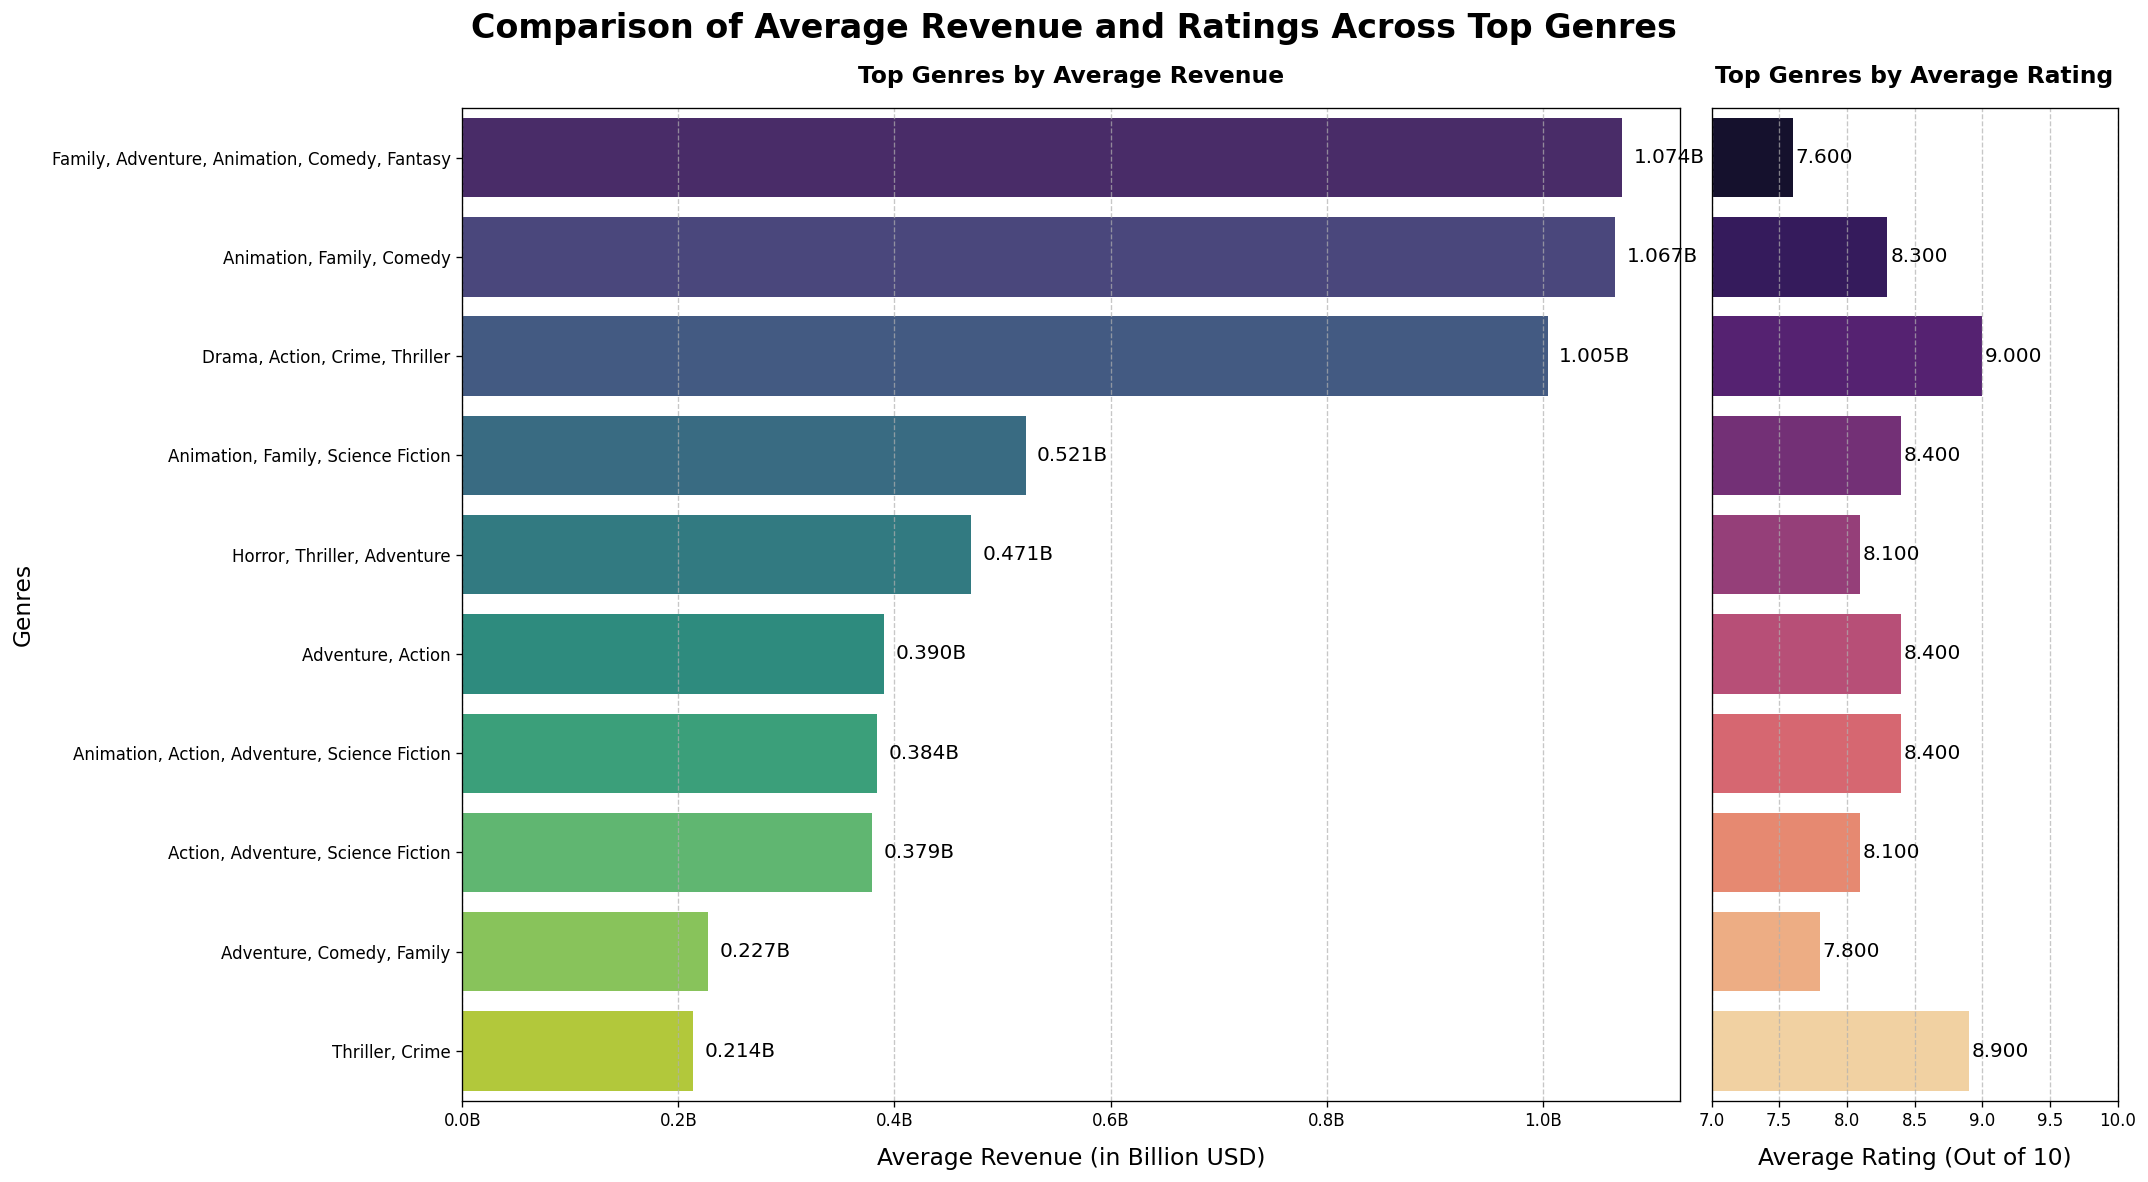

In [ ]:

df_genres = df_merged_cleaned.explode('genres')

genre_summary = df_genres.groupby('genres').agg(
    avg_revenue=('revenue', 'mean'),
    avg_rating=('rating', 'mean'),
    movie_count=('title', 'count')
).sort_values(by='avg_revenue', ascending=False).reset_index()

# Filter for top 10 genres by revenue for clarity
top_genres = genre_summary.head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [3, 1]}, dpi=120)

# Bar plot for average revenue
sns.barplot(
    data=top_genres, 
    x='avg_revenue', 
    y='genres', 
    ax=axes[0], 
    palette='viridis'
)
axes[0].set_title('Top Genres by Average Revenue', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Average Revenue (in Billion USD)', fontsize=14, labelpad=10)
axes[0].set_ylabel('Genres', fontsize=14, labelpad=10)
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e9:.1f}B'))  # Convert revenue to billions
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Bar plot for average rating
sns.barplot(
    data=top_genres, 
    x='avg_rating', 
    y=top_genres['genres'], 
    ax=axes[1], 
    palette='magma'
)
axes[1].set_title('Top Genres by Average Rating', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Average Rating (Out of 10)', fontsize=14, labelpad=10)
axes[1].set_ylabel('')  # No y-label on the right plot
axes[1].set_xlim(7, 10)  # Focus on ratings in the range of interest
axes[1].yaxis.set_visible(False)  # Hide genre names on the right plot
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

# Enhance overall layout and design
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle(
    'Comparison of Average Revenue and Ratings Across Top Genres', 
    fontsize=20, fontweight='bold', y=0.98
)

# Add annotations to bars for better readability and alignment
for ax, metric, fmt, alignment_offset in zip(
    axes, 
    ['avg_revenue', 'avg_rating'], 
    [lambda x: f'{x / 1e9:.3f}B', lambda x: f'{x:.3f}'],  
    [0.01 * max(top_genres['avg_revenue']), 0.02]  
):
    for bar, value in zip(ax.patches, top_genres[metric]):
        ax.text(
            bar.get_width() + alignment_offset,  
            bar.get_y() + bar.get_height() / 2, 
            fmt(value), 
            va='center', fontsize=12, color='black'
        )

plt.show()
